# Entry Guidance

In [2]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn
from importlib import reload
seaborn.set_style("whitegrid")
from scipy.io import loadmat, savemat

from EntryGuidance import Mesh 
from EntryGuidance import EntryEquations as EE
from EntryGuidance import MonteCarloV as MC
from EntryGuidance import Parachute 
from Utils import DA 
from Utils.submatrix import submatrix 
from Utils.smooth import smooth 

import EntryGuidance.Convex_PS as Convex
reload(Convex)
OCP = Convex.OCP
import cvxpy as cvx

In [3]:
reload(Mesh)
reload(EE)
# reload(CVX)
reload(MC)
reload(DA)

<module 'Utils.DA' from 'C:\\Users\\cdnoyes\\Documents\\EDL\\Utils\\DA.py'>

Iteration 0
status:        optimal
optimal value: 2.609
solution time:  0.603 s
setup time:     0.367 s
penalty value:  1.5242289156729417e-12

Iteration 0
status:        optimal
optimal value: 2.606
solution time:  0.806 s
setup time:     0.648 s
penalty value:  5.302164721213849e-11

Iteration 0
status:        optimal
optimal value: 2.592
solution time:  1.031 s
setup time:     1.017 s
penalty value:  1.3326146146876247e-08

Iteration 0
status:        optimal
optimal value: 2.592
solution time:  1.284 s
setup time:     1.529 s
penalty value:  7.594402877141111e-09

Iteration 0
status:        optimal
optimal value: 2.593
solution time:  1.577 s
setup time:     1.96 s
penalty value:  3.4543012337246705e-09

Iteration 0
status:        optimal
optimal value: 2.59
solution time:  1.929 s
setup time:     2.639 s
penalty value:  8.953497771630235e-09

Iteration 0
status:        optimal
optimal value: 2.59
solution time:  2.327 s
setup time:     3.029 s
penalty value:  2.723953254205379e-09


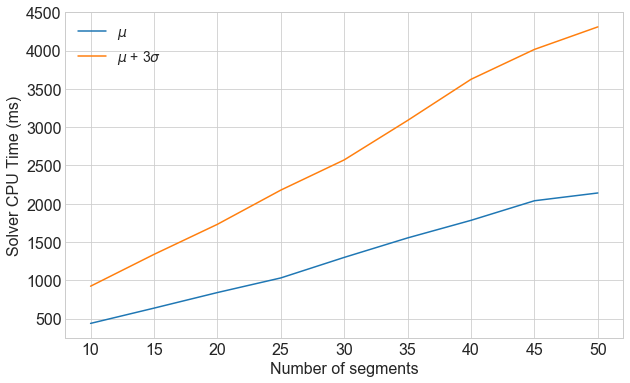

In [5]:
vdp = Convex.TestClass(mu=0.5, x0=[2, 2], xf=[0, 0], tf=8)

guess = {}
    
t = np.linspace(0,3,20)
u = np.zeros_like(t)
# x = np.array([np.linspace(vdp.x0[i],0,20) for i in [0,1]]).T #
x = vdp.integrate(vdp.x0, 0, t)
guess['state'] = x
guess['control'] = u 
guess['time'] = t 
Ntimes = 20
Nsegments = [10, 15, 20, 25, 30, 35, 40, 45, 50]
# Nsegments = [10,15]
Tall = []
for i in range(Ntimes):
    T = []
    for N in Nsegments:
        guess['mesh'] = [4]*N
        vdp.solve(guess, max_iter=1)
        T.append(vdp.sol_history['sol_time'][0])
    
    Tall.append(T)
    


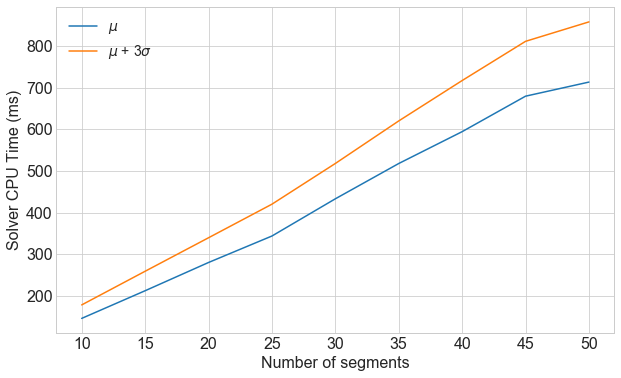

In [10]:
T = np.mean(Tall, axis=0)/3 # Ntimes x nsegments
S = np.std(Tall, axis=0)/15

plt.figure(figsize=(10,6))
plt.plot(Nsegments, T*1000, label='$\mu$')
plt.plot(Nsegments, (T+3*S)*1000, label="$\mu$ + 3$\sigma$")

plt.xlabel("Number of segments", fontsize=16)
plt.ylabel("Solver CPU Time (ms)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.savefig("./results/convex/solver_times.png", bbox_inches='tight', pad_inches=0.1)


In [3]:
print(plt.style.available)
plt.style.use('seaborn-whitegrid')

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', '_classic_test']


In [43]:
class Entry(OCP):
    
    def __init__(self, current_state, scale=True, energy=True,):
        """current state should be the original states with units"""
        model=EE.Entry(Scale=scale, Energy=energy)
        self.model = model 
        self.x0 = self.model.scale(current_state)
        self.energy = energy
        self.scale = scale 
        self.lon_target = None 
        self._lweight = 1 
        
    def set_lagrange_weight(self, weight):
        self._lweight = weight
        
    def dynamics(self, x, t, u):
        # x comes in as six states and bank
        
        xnew = x[:6].copy()
        xnew = np.concatenate((xnew, np.zeros((1,t.size))), axis=0) # range to go
        xnew = np.concatenate((xnew, np.ones((1,t.size))*self.x0[-1]), axis=0)     # mass 
        
        unew = np.concatenate((x[6:], np.zeros((2, t.size))), axis=0)
        
        dx = self.model.dynamics(unew)(xnew, t)[:6]
        dx = np.concatenate((dx, (u[:,None].T/self.model.dE)), axis=0)
        return dx
    
    def mayer(self, xf):
        max_alt = 1-xf[0] # Maximize altitude 
        min_miss = 100*(cvx.abs(xf[2]) + cvx.abs(xf[1]-self.lon_target))
#         min_miss_norm = 1e2*cvx.norm(x[-1][1:3] - np.array([self.lon_target, 0]))

#         return cvx.Problem(cvx.Minimize(max_alt))
#         return cvx.Problem(cvx.Minimize(max_alt + min_miss))  
#         return cvx.Problem(cvx.Minimize(min_miss))  

        # return cvx.Problem(cvx.Minimize(cvx.abs(xf[2]))) # Minimize crossrange with abs
#         return cvx.Problem(cvx.Minimize(3397*cvx.power(xf[2], 2))) # Minimize crossrange with quadratic form 
        return 0 

    def lagrange(self, t, x, u, xr, ur, v):
#         print(u.shape)
        U = u.copy()
        U = np.append(U, u[-1])
#         X = x.copy()
#         X = np.append(X, x[-1])
        e = 1 + 0.5*xr[:,3]**2 - 1/xr[:,0]
        de = np.abs(np.diff(e))
        de = np.append(de, de[-1])
#         print(de)
#         de = np.abs(e[0]-e[-1])

#         return 0*1e3*np.array([cvx.norm(vi, 2) for vi in v]) + 1e-2*np.array([cvx.abs(ui-uri) for ui,uri in zip(U,U[1:])])

#         return 1*np.array([cvx.norm(ui-uri) for ui,uri in zip(x, xr)]) + 1e-5*np.array([cvx.abs(ui-uri) for ui,uri in zip(U,U[1:])])
#         return 1e2*np.array([cvx.norm(ui[1:3]-uri[1:3]) for ui,uri in zip(x, xr)])/(xr[:,3]) # Promotes nearness to the original traj 
#         return 1e-2*np.array([cvx.abs(ui[-1]-uri[-1]) for ui,uri in zip(x, xr)])#/np.abs(e[0]-e[-1]) # Promotes nearness to the original bank angle profile 

        return self._lweight*np.array([cvx.abs(ui-uri) for ui,uri in zip(U,U[1:])]) # Promotes zero changes in rate (stair-step bank rates)
#         return 1e-3*np.array([cvx.abs(ui-uri)/d for ui,uri,d in zip(U,U[1:],de)]) # Promotes zero changes in rate (stair-step bank rates)

    
#         return 1e-7*np.array([cvx.power(ui-uri, 2) for ui,uri in zip(U,U[1:])]) # Promotes small changes in rate - doesnt seem to work well 
#         return 1e-13*np.array([cvx.abs(ui[6]-uri[6]) for ui,uri in zip(X,X[1:])]) # Promotes flatter bank angles 

#         return 1e-5*np.array([cvx.abs(ui-uri) for ui,uri in zip(u,ur)])
#         return 1e-5*np.array([cvx.norm(ui-uri, 2) for ui,uri in zip(u,ur)])

#         return 1 * ((u-ur))**2
#         return 1e-3*np.array([cvx.norm(ui) for ui in u])
#         return np.array([cvx.norm(x) for ui in u])
        return np.zeros((len(x),))

    def constraints(self, t, x, u, x_ref, u_ref):
        bc = [x[0] == x_ref[0]]   # Initial condition
        bc += [x[-1][3] < 475/self.model.vel_scale]      # Final velocity constraint
        bc += [x[-1][0] > 1 + 6e3/self.model.dist_scale]
#         bc += [x[-1][2] < 3.8313e-05, x[-1][2] > -3.8313e-05] # Small crossrange as a constraint, 8.8e-5 rad is 300 meters 
#         bc += [x[-1][2] == 0]           # Zero crossrange as constraint
#         bc += [x[-1][1] == self.lon_target] # Final downrange as constraint
        bc += [cvx.norm(x[-1][1:3] - np.array([self.lon_target, 0])) < 1e-5] # Bound on the total distance (DR and CR) from target 
#         bc += [cvx.abs(x[-1][6]) <= np.radians(10)] # Bank angle within ten deg of lift up 
        
        its = list(range(len(t)))
        constr = []
        for it,xi,xr,ui,ur in zip(its,x,x_ref,u,u_ref):
#             if it: # not first iter
#                 constr.append(cvx.abs((ui-u[it-1])) < np.radians(5.)*self.model.time_scale)
                
            
            # Path constraints 
#             constr.append(xi[0] >= 0) # positive radius 
            
            # Control Limitations
            if t[it] > 0.18: #0.18:
                constr.append(cvx.abs(ui) < np.radians(20.)*self.model.time_scale) # maximum bank rate
                constr.append(cvx.abs(xi[6]) < np.radians(90.))                    # bank angle limits

            else:
                constr.append(cvx.abs(ui) < np.radians(3.)*self.model.time_scale) # maximum bank rate
                constr.append(cvx.abs(xi[6]) < np.radians(35.))                    # bank angle limits
            
            # Trust regions 
#             constr.append(cvx.abs(xi[1]-xr[1]) < np.radians(0.08)) # longitude
#             constr.append(cvx.abs(xi[2]-xr[2]) < np.radians(0.05)) # latitude, 0.15 deg is ~9 km, .08 ~5km
#             constr.append(cvx.abs(xi[3]-xr[3]) < 10./self.model.vel_scale) # vel
#             constr.append(cvx.abs(xi[0]-xr[0]) < 500./self.model.dist_scale) # radius
#             constr.append(cvx.abs(xi[6]-xr[6]) < np.radians(15.)) # bank angle

        return bc + constr

    def jac(self, x, u):
        # u will be bank rate
        # x will be 6 states + bank angle
        
        # U needs to be [bank, Thrust, Mu]
        # X needs to be 6 states, downrange, mass

        # ought to be vectorized if possible 
        U = np.concatenate((x[6:], np.zeros((2,x.shape[1]))), axis=0).T
        X = np.concatenate((x[0:6], np.ones((2,x.shape[1]))*self.x0[-1]), axis=0).T     
                
        self.model.DA(True)    
        rows = list(range(6))
        cols = rows + [8]
        J = np.array([submatrix(self.model.jacobian(Xi, Ui, vectorized=False),rows,cols) for Xi, Ui in zip(X,U)]) # N x 8 x 11
        J2 = np.array([self.model.bank_jacobian(Xi, Ui, sdot) for Xi,Ui,sdot in zip(X, U, u)]) # N x 8 x 12?! 
        self.model.DA(False)
        
        B = np.zeros((X.shape[0], 7, 1))
        B[:,-1,0] = J2[:,0,-1]

        J2 = J2[:,:,cols]  # Get rid of the extra terms we dont care about
        A = np.concatenate((J,J2), axis=1)        
        return A, B
        
    def solve_ocp(self, dr=885., cr=1., fpa_min=-45, azi_max=5.):
        """ Solves for an optimal trajectory
            dr - total downrange flown
            fpa_min - lower bound on FINAL flight path angle (set too high and the problem will be infeasible)
            azi_max - two-sided bound on FINAL heading angle 
        
        """
        from Utils.gpops import entry
        from scipy.interpolate import interp1d
        from math import pi
        import time 
        
        def rad(num):
            return float(num)*pi/180.
        t0 = time.time()
        traj = entry([float(dr), float(cr), rad(fpa_min), rad(azi_max)])
        print("Total OCP solution time {:.2f} s".format(time.time()-t0))
        sigma = np.squeeze(np.array(traj['state'])[:,-1])

        bankProfile = interp1d(np.squeeze(np.squeeze(traj['energy'])), sigma, fill_value=(sigma[0],sigma[-1]), assume_sorted=False, bounds_error=False, kind='cubic')
        return bankProfile, np.array(traj['state'])
    
    def guess(self, dr=875, cr=0):
        """ Generates an initial guess """
        from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
        from EntryGuidance.InitialState import InitialState
        from Utils.submatrix import submatrix
        from EntryGuidance.Mesh import Mesh
        from scipy.interpolate import interp1d
        
        print("Solving optimal control problem...")
        bankProfile,traj = self.solve_ocp(dr=dr, cr=cr)

        print("    Integrating solution...")
        x0 = self.model.unscale(self.x0)
        Vf = traj[-1,3]

        sim = Simulation(cycle=Cycle(0.1), output=False, **EntrySim(Vf=Vf))
        res = sim.run(x0, [lambda **d: bankProfile(d['energy'])])
        
        sigma_dot = np.diff(sim.control_history[:,0])/np.diff(sim.times) # rad/s 
        sigma_dot = np.append(sigma_dot, sigma_dot[-1]) # To make it the same length
        
        X = np.concatenate((self.model.scale(sim.history)[:,0:6], sim.control_history[:,0:1]), axis=1)
        
        # Output the correctly scaled guess 
        guess = {}
        self._guess = guess 
        
        guess['control'] = sigma_dot * self.model.time_scale# Bank rate 
        guess['state'] = X# 6 states + bank 
        if self.energy:
            guess['time'] = sim.df['energy'].values / (self.model.vel_scale**2)
        else:
            guess['time'] = self.model.scale_time(sim.times)
        
        guess['mesh'] = [3]*50
        print("Guess generated.")
        
        e = guess['time']
        edot = -sim.history[:,3]*sim.df['drag'].values / self.model.vel_scale / self.model.acc_scale
        guess['rate'] = edot

#         edot_est = np.diff(e) / np.diff(self.model.scale_time(sim.times ))
#         plt.plot(e[:-1], edot_est, '--')
#         plt.show()
        return guess.copy()
    
#     def guess_from_traj(self):

    def set_target(self, lon):
        self.lon_target = lon 

    def uncertainty(self, K=1): # MSL-like dispersions, according to Soumyo Dutta paper on reconstruction 
        import chaospy as cp 
        
        R = cp.Normal(0, 32/3)/self.model.dist_scale * K
        V = cp.Normal(0, 0.026/3)/self.model.vel_scale * K                       # Entry velocity deviation
        lon = cp.Normal(0, np.radians(0.000781/3)) * K
        lat = cp.Normal(0, np.radians(0.00036/3)) * K 
        gamma = cp.Normal(0, np.radians(0.0004/3.0))* K       # Entry FPA deviation, 
        azi = cp.Normal(0, np.radians(0.0003/3.0))*K       # Entry Azimuth deviation, 
        s0 = cp.Normal(0, np.radians(0.0003/3.0)) # redundant 
        m0 = cp.Normal(0, 0.0001/3)
        return cp.J(R,lon,lat,V,gamma,azi,s0,m0)
        
    
    def plot(self, T, U, X, J, meshpts, Tcvx):
        fontsize= 16

        
        if not J:
            return 
    
        it = list(range(len(T)))
        if len(J) > 1:
            plt.figure(1)
            plt.plot(it[:-1], J)
            plt.xlabel('Iteration')
            plt.xticks(it)
            plt.ylabel('Objective Function')
        
        
            for iteration, t, u, xs in zip(it,T,U,X):
                label = "{}".format(iteration)
                sigma = np.degrees(xs[6])
                x = xs[0:6] * self.model._scale[0:6, None]
                r,th,ph,v,gam,psi = x
                h = self.model.altitude(r, km=True)

                plt.figure(2)
                plt.plot(v, h, label=label)
                plt.xlabel('Velocity (m/s)')
                plt.ylabel('Altitude (km)')

                plt.figure(3)
                plt.plot(th*3397, -3397*ph, label=label)
                plt.xlabel('Downrange (km)')
                plt.ylabel('Crossrange (km)')

                plt.figure(4)
                plt.plot(t, sigma, label=label)

                plt.figure(5)
                plt.plot(t, np.degrees(u)/self.model.time_scale, label=label)
                plt.ylabel('Bank Rate (deg/s)')
            
            for i in range(2,6):
                plt.figure(i)
                plt.legend()
            
        t, u, xs = T[-1], U[-1], X[-1]    
        label = "Updated"    
        sigma = np.degrees(xs[6])
        x = xs[0:6] * self.model._scale[0:6, None]
        r,th,ph,v,gam,psi = x
        h = self.model.altitude(r, km=True)
        dr,cr = self.model.planet.range(th[0],ph[0],psi[0]*0,th,ph, km=True)
        dr += th[0]*3397

        plt.figure(6)
        plt.plot(v, h, label=label)
        plt.xlabel('Velocity (m/s)')
        plt.ylabel('Altitude (km)')
        plt.title("Final {:.2f} km at {:.0f} m/s".format(h[-1],v[-1]))

        plt.figure(7)
#         plt.plot(th*3397, -3397*ph, label=label)
        plt.plot(dr, cr, label=label)

        plt.xlabel('Downrange (km)')
        plt.ylabel('Crossrange (km)')

        plt.figure(10)
        plt.plot(v, np.degrees(gam), label=label)
        plt.xlabel('Velocity (m/s)')
        plt.ylabel('FPA (deg)')
        
        plt.figure(11)
        plt.plot(v, np.degrees(psi), label=label)
        plt.xlabel('Velocity')
        plt.ylabel('Heading (deg)')
        
        plt.figure(8)
        plt.plot(t, sigma, label=label)
        plt.ylabel('Bank Angle (deg)')
        
        plt.figure(9, figsize=(10,6))
        plt.plot(v, np.degrees(u)/self.model.time_scale, label=label)
        plt.ylabel('Bank Rate (deg/s)', fontsize=fontsize)
        plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)



    def entry_plot(self, df, guess, label='Integrated', fix=False):
        if fix:         # Use a line search to draw a trajectory with some error but looks much closer to CVX 

            from scipy.interpolate import interp1d

            xc = self.sol['state'][:6] * self.model._scale[0:6, None]
            r,th,ph,v,gam,psi = xc
            h = self.model.altitude(r, km=True)
            e = self.model.energy(r, v)
            dr,cr = self.model.planet.range(th[0],ph[0],psi[0]*0,th,ph, km=True)
            dr += th[0]*3397
            
            x = guess['state']
            ti = guess['time']
            t = self.mesh.times 
            # Interpolate the guess onto the initial mesh
            x = interp1d(ti, x, axis=0, bounds_error=False, fill_value='extrapolate', kind='cubic')(t).T
            xg = x[:6] * self.model._scale[0:6, None]
            rg,thg,phg,vg,gamg,psig = xg
            hg = self.model.altitude(rg, km=True)
            drg,crg = self.model.planet.range(thg[0],phg[0],psig[0]*0,thg,phg, km=True)
            drg += thg[0]*3397
            
#             eta = 0.85
            eta = np.clip(np.sort(np.random.random(rg.shape)), 0, 0.85)
            v = v*eta + (1-eta) * vg
            h = h*eta + (1-eta) * hg
            
            eta2 = np.linspace(0.5,1,rg.size)
            dr = eta2 * dr + (1-eta2)*drg
            cr = eta2 * cr + (1-eta2)*crg
            
            fpa = np.degrees(eta * gam + (1-eta)*gamg)
            heading = np.degrees(eta * psi + (1-eta)*psig)
        
        else:
            v = df['velocity']
            h = df['altitude']
            dr0 = np.radians(df['longitude'])[0]*3397
#             cr = -np.radians(df['latitude'])*3397
            fpa = df['fpa']
            heading= df['heading']
            th = np.radians(df['longitude'])
            ph = np.radians(df['latitude'])
            dr,cr = self.model.planet.range(th[0],ph[0],heading[0]*0,th,ph, km=True)
            dr += dr0
            
        plt.figure(6)
        plt.plot(v, h, label=label)
        plt.legend()

        plt.figure(7)
        plt.plot(dr, cr, label=label)
        plt.xlabel('Downrange [km]')
        plt.ylabel('Crossrange [km]')
        plt.legend()
        
        plt.figure(10)
        plt.plot(v, fpa, label=label)
        plt.xlabel('Velocity')
        plt.ylabel('FPA (deg)')
        
        plt.figure(11)
        plt.plot(v, heading, label=label)
        plt.xlabel('Velocity')
        plt.ylabel('Heading (deg)')
                
        
def integrate_cvx(sol):
    from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
    from scipy.interpolate import interp1d
    
    model=EE.Entry(Scale=True, Energy=True)
    
    xs = np.array(sol['state']).squeeze().T
    x = xs.copy()
    x[:,0] = x[:,0]*model.dist_scale
    x[:,3] = x[:,3]*model.vel_scale
    e = model.energy(x[:,0], x[:,3], False)
    
#     print(x.shape)
    # Unscale the states
    # Compute e (or use velocity instead)
    
    fun = interp1d(e, x[:,-1], bounds_error=False, fill_value=(x[-1,-1],x[0,-1]), kind='cubic')
    bankProfile = lambda **d: fun(d['energy'])

    x0_new = np.append(x[0,0:6], 0)
    x0_new = np.append(x0_new, 2804) # need mass here 
    
#     print("Vf = {}".format(x[-1,3]))
    print("x0 (scaled) = {}".format(xs[0,0:6]))
    sim = Simulation(cycle=Cycle(0.2), output=False, **EntrySim(Vf=x[-1,3]))
    res = sim.run(x0_new, [bankProfile])
    
    return sim.df 

def plot_guess(entry, guess):
    x = guess['state']
    r,th,ph,v,gamma,psi,bank = x.T
    h = entry.model.altitude(r*entry.model.dist_scale, km=True)
    dr = th*3397
    cr = -ph*3397
#     dr,cr = entry.model.planet.range(th[0],ph[0],psi[0],th,ph, km=True)
#     dr += th[0]*3397
    
    label = 'Original'
    
    plt.figure(6)
    plt.plot(v*entry.model.vel_scale, h, label=label)
    plt.legend()

    plt.figure(7)
    plt.plot(dr, cr, 'k--',label=label)
    plt.xlabel('Downrange (km)')
    plt.ylabel('Crossrange (km)')
    plt.legend()

    plt.figure(8)
    plt.plot(guess['time'], np.degrees(bank), 'k--', label=label)
    plt.legend()

    plt.figure(9)
    plt.plot(v*entry.model.vel_scale, np.degrees(guess['control'])/entry.model.time_scale, 'k--', label=label)
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Bank Rate (deg/s)')
    plt.legend()
    
    plt.figure(10)
    plt.plot(v*entry.model.vel_scale, np.degrees(gamma), label=label)
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('FPA (deg)')
    plt.legend()
    
    plt.figure(11)
    plt.plot(v*entry.model.vel_scale, np.degrees(psi), label=label)
    plt.xlabel('Velocity')
    plt.ylabel('Heading (deg)')
    plt.legend()
    
    

In [44]:
from EntryGuidance.InitialState import InitialState
entry = Entry(InitialState(), scale=True, energy=True)
# s = entry.uncertainty().sample(100)


Solving the OCP in the guess generation is slow so it gets its own cell

In [28]:
guess0 = entry.guess(dr=880., cr=0)

Solving optimal control problem...
Total OCP solution time 7.90 s
    Integrating solution...
Guess generated.


E:\Documents\EDL\EntryGuidance\Planet.py:113: RuntimeWarning: invalid value encountered in double_scalars
  PHI = np.sign(lonc-lon0)*arccos( (sin(latc) - sin(lat0)*cos(d13))/(cos(lat0)*sin(d13)) )


[ 1.00523453e+00  2.38668577e-01 -8.30533082e-06  2.57018408e-01
 -1.15472928e-02  3.26930963e-02  9.51659881e-03]


In [29]:
# don't want to actually start from true x0 
import copy 
guess = copy.deepcopy(guess0)
v0 = 4400/entry.model.vel_scale
idx = np.argmin(np.abs(guess0['state'][:,3]-v0)) # Find index closest to desired v0 
for key in guess.keys():
    if not key in 'mesh':
        guess[key] = guess0[key][idx:]



In [26]:
print(guess0['state'][idx])
print(guess0['state'][-1])

[ 3.42502374e+06  1.71524308e-01 -8.41070381e-05  4.40309980e+03
 -9.17318556e-02 -7.11865775e-03  2.62462666e-01]
[ 3.40783802e+06  2.56567082e-01 -1.59279169e-05  4.69985322e+02
 -2.93880444e-01  2.06932477e-02  1.62797532e-01]


Iteration 0
status:        optimal_inaccurate
optimal value: 107.665
solution time:  1.059 s
setup time:     0.81 s
penalty value:  0.0107676474021261



E:\Documents\EDL\EntryGuidance\Planet.py:113: RuntimeWarning: invalid value encountered in true_divide
  PHI = np.sign(lonc-lon0)*arccos( (sin(latc) - sin(lat0)*cos(d13))/(cos(lat0)*sin(d13)) )


Iteration 0
status:        optimal
optimal value: 114.145
solution time:  0.736 s
setup time:     0.958 s
penalty value:  0.010851108463540414



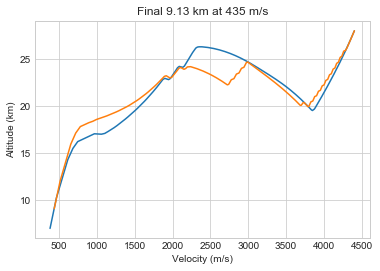

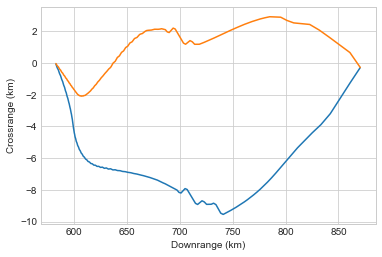

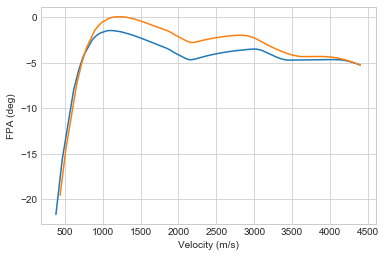

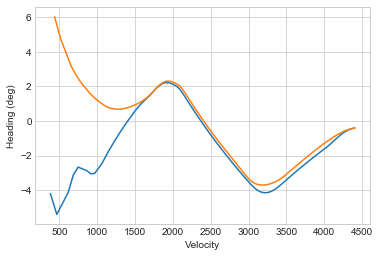

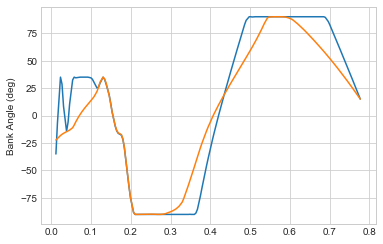

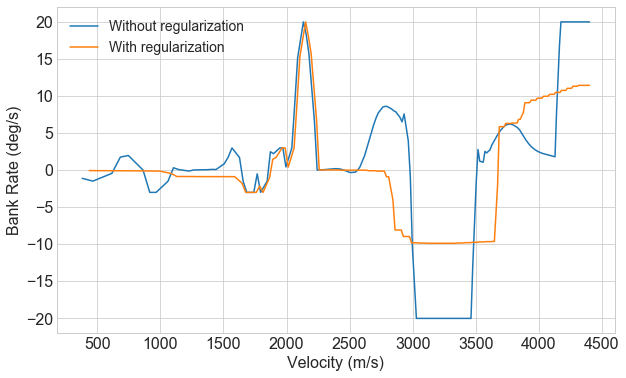

In [51]:
u_ref = copy.deepcopy(guess['control'])
u_smooth = smooth(-guess['time'], u_ref, tau=0.008)(-guess['time'])
guess['mesh'] = [3]*50
guess['control'] = u_smooth * 1
def pen(it):
#     return 2**it * 1e2
    return 1e4 

entry.set_target(guess['state'][-1,1] - 1/3397)
entry.set_lagrange_weight(1e-12)
sol = entry.solve(copy.deepcopy(guess), max_iter=1, max_size=800, penalty=pen, plot=True, linesearch=1, refine=False, solver='ECOS')
entry.set_lagrange_weight(1)
sol = entry.solve(copy.deepcopy(guess), max_iter=1, max_size=800, penalty=pen, plot=True, linesearch=1, refine=False, solver='ECOS')

plt.figure(9)
plt.legend(("Without regularization", 'With regularization'),fontsize=14)
plt.savefig("./results/convex/regularize.png", bbox_inches='tight')
# sol_integrated = integrate_cvx(entry.sol)
# entry.entry_plot(sol_integrated, copy.deepcopy(guess), fix=True)
# plot_guess(entry, copy.deepcopy(guess))

### Model Checking
- Verify Jacobians (and possibly Hessian) by comparing $f(x+\delta x)\approx f(x) + J(x)\delta x$
- Verify again but in scaled variables 

In [47]:
model = EE.Entry(Scale=True)

In [64]:
idx = 1000

state = np.array(guess['state'])[idx,0:6]
state = np.append(state, 0.)
state = np.append(state, 2804.)

state2 = np.array(guess['state'])[idx+1,0:6]
state2 = np.append(state2, 0.)
state2 = np.append(state2, 2804.)

control = [np.array(guess['state'])[idx,6], 0, 0]
control2 = [np.array(guess['state'])[idx+1,6], 0, 0]

control = [0, 0, 0]
control2 = [0.25, 0, 0]

# print("FPA: {:.2f} deg".format(np.degrees(state[4])))

model.use_energy = True
F = model.dynamics(control)(state, 0)
model.DA(True)
rows = list(range(6))
cols = rows + [8]
J = submatrix(model.jacobian(state, control, vectorized=False),rows,cols)
A = J[:,rows]
B = J[:,-1]
model.DA(False)

F2 = model.dynamics(control2)(state2, 0)[:6]
F2a = F[:6] + A.dot((state2[0:6]-state[0:6])) + B.dot(control2[0]-control[0])
print("True Der   = {}".format(F2))
print("Lin Approx = {}\n".format(F2a))

err = np.abs(F2-F2a)
perr = np.abs(F2-F2a)/np.abs(F2) * 100
perr[np.isnan(perr)] = 0
print("Errors = {}\n".format(err))

print("% Errors = {}\n".format(perr))
# print(err)
# print(perr)
imax = np.argmax(perr)
print("Maximum error = {:.4g}, {:.2f}%, in index {}".format(err[imax], perr[imax],imax))

True Der   = [ 0.11275481 -0.77323339 -0.01595517  5.16277793 14.99721657  2.64254136]
Lin Approx = [ 0.11275423 -0.77323203 -0.01595514  5.16277636 14.66839128  2.66264208]

Errors = [5.85090794e-07 1.36244563e-06 2.85020379e-08 1.56647563e-06
 3.28825283e-01 2.01007227e-02]

% Errors = [5.18905378e-04 1.76201085e-04 1.78638291e-04 3.03417201e-05
 2.19257541e+00 7.60658772e-01]

Maximum error = 0.3288, 2.19%, in index 4


Reachable Set Analysis from Matlab

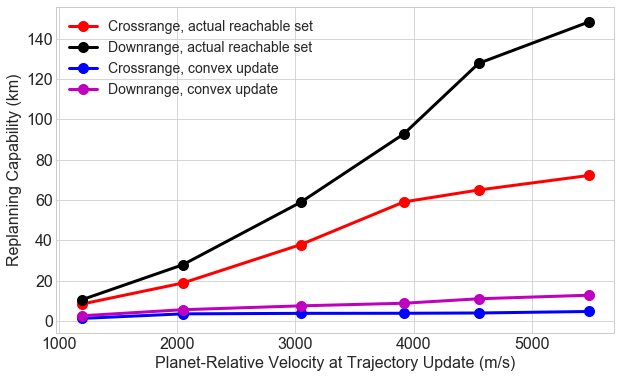

In [14]:
def collect(parent_dir):
    Collection = {}
    
    for rs in os.listdir(parent_dir): # for each reachable set computation
        dir_path = os.path.join(parent_dir, rs)    

        if not os.path.isdir(dir_path):
            continue 
            
        Data = []

        for filename in os.listdir(dir_path):
            if not filename.endswith('.mat'):
                continue

            Data.append(loadmat(os.path.join(dir_path, filename), squeeze_me=True))
        
        Collection[rs] = Data 
    return Collection


def plot_rs_radius(data, Ns=[400,550,600,675,800,1000], fs=16, figsize=(10,6)):   
    if Ns is None:
        Ns = data.keys()
    
    
    traj_lists = [data[str(N)] for N in Ns] # Nx x 18 
    v0 = np.array([traj_list[0]['state'][0,3] for traj_list in traj_lists])
    idx = np.argsort(v0)

    crs = np.array([[tr['state'][-1,2] for tr in traj_list] for traj_list in traj_lists]) # Something like 4 x 18 
    cr = np.max(np.abs(crs), axis=1)[idx]*3397
    
    drs = np.array([[tr['state'][-1,1] for tr in traj_list] for traj_list in traj_lists]) # Soomething like 4 x 18 
    dr = (np.max(drs, axis=1) - np.min(drs, axis=1))[idx]*3397/2

    v0 = v0[idx]
    
    plt.figure(2, figsize=figsize)
    plt.plot(v0, cr,'ro-', label='Crossrange, actual reachable set', linewidth=3, markersize=10)
    plt.plot(v0, dr,'ko-', label='Downrange, actual reachable set', linewidth=3, markersize=10)
    
    n = len(v0)
    cr_cvx = np.linspace(2, 5, n) + np.random.uniform(low=-1,high=1,size=(n,))
    dr_cvx = np.linspace(3.5, 11, n) + np.random.uniform(low=-1,high=2,size=(n,))
    plt.plot(v0, cr_cvx,'bo-', label='Crossrange, convex update', linewidth=3, markersize=10)
    plt.plot(v0, dr_cvx,'mo-', label='Downrange, convex update', linewidth=3, markersize=10)
    
    plt.xlabel('Planet-Relative Velocity at Trajectory Update (m/s)', fontsize=fs)
    plt.ylabel('Replanning Capability (km)', fontsize=fs)
    plt.legend(fontsize=fs-2)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.savefig("./results/convex/reachable_radii.png", bbox_inches='tight', pad_inches=0.1)

               
def plot_rs(data, Ns=[400,550,600,675,800,1000], fs=16, figsize=(8,6), annotate=False):
    if Ns is None:
        Ns = data.keys()
        
    for N in Ns:    
        
        traj_list = data[str(N)]
        xf = np.array([traj['state'][-1] for traj in traj_list]).T 
        
        idxs = list(np.argsort(xf[1])[:-1])
        imin = np.argmin(xf[2,idxs]) # zero crossrange point 
        idx = [idxs[imin]] + idxs[:imin] + idxs[1+imin:]

        
        plt.figure(1, figsize=figsize)
        L = plt.plot(xf[1,idx]*3397, xf[2,idx]*3397, 'x-', label="$V_0$ = {:.0f} m/s".format(traj_list[0]['state'][0,3]))
        plt.plot(xf[1,idx]*3397, -xf[2,idx]*3397, 'x-', color=L[-1].get_color())
    plt.xlabel('Downrange (km)', fontsize=fs)
    plt.ylabel('Crossrange (km)', fontsize=fs)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
#     plt.title('Reachable Set from Different Initial Energy Levels', fontsize=fs)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)

    if annotate:
        plt.gca().annotate('Minimum downrange', xy=(738, 33), xytext=(741, 31),fontsize=fs)
    #             arrowprops=dict(facecolor='black', shrink=0.01),)

        plt.gca().annotate('Minimum downrange,\nzero crossrange constraint', xy=(738, 0), xytext=(753, -8),fontsize=fs)
    #             arrowprops=dict(facecolor='black', shrink=0.05),)

        plt.gca().annotate('Maximum\ndownrange', xy=(738, 36), xytext=(978, -10),fontsize=fs)
        plt.gca().annotate('Maximum crossrange \nfor various downrange targets', xy=(738, 0), xytext=(823, -58),fontsize=fs)

        plt.savefig("./results/convex/reachable_set.png", bbox_inches='tight')
    
    
RS = collect(r"./results/Fixed Initial Bank Angle")
# plot_rs(RS, fs=18, figsize=(10,6), Ns=None, annotate=False) # 
plot_rs_radius(RS, fs=16, figsize=(10,6))

In [105]:
RS['400'][0]['state'][0]

array([ 3.44798709e+06,  1.23845619e-01,  0.00000000e+00,  5.48299238e+03,
       -1.69371202e-01,  0.00000000e+00,  0.00000000e+00])

Next, we need a quick utilities for integrating a CVX solution, plotting the integration vs optimization, and computing a metric for quantifying the discrepancy. The metric could be something like $\int_{E_0}^{E_f} ||x_{int}-x_{opt}||  dE$, or alternatively, depending solely on the difference in final states $||x_{int}(E_f)-x_{opt}(E_f)||$? Although these might tell a story, perhaps using several metrics with physical meaning might be better, such as the individual differences between final altitude, and final horizontal difference (no reason to separate DR/CR errors, I think)

Conduct a vectorized monte carlo of the open loop optimal control 

In [177]:
from EntryGuidance.InitialState import InitialState
entry = Entry(InitialState(), scale=False, energy=True)

In [188]:

bankProfile, X = entry.solve_ocp(950, 0)
r,th,ph,v,fpa,psi,bank = X.T 

m0 = InitialState()[-1]
s0 = 0 
X[:,6] = s0
X = np.concatenate((X, np.ones((X.shape[0],1))*m0), axis=1)


Total OCP solution time 14.59 s


In [189]:
N = 500
dx0 = entry.uncertainty(K=50).sample(N) # entry should be unscaled so that these samples have correct units before going into the vectorized integration
x0 = dx0 + X[0][:,None]

In [190]:
reload(MC)
mc = MC.MonteCarlo()
mc.reference_data(lambda **d: bankProfile(d['energy']), Vf=v[-1])
# mc.sample(N)
mc.samples=np.zeros((4,N)) # No parametric uncertainty 
mc.set_controls([bankProfile])
mc._run(x0, Ef=entry.model.energy(r,v, False)[-1])

Generating reference data...
...done. 
(1781, 8)
(421, 8, 500)
(1, 500, 8)


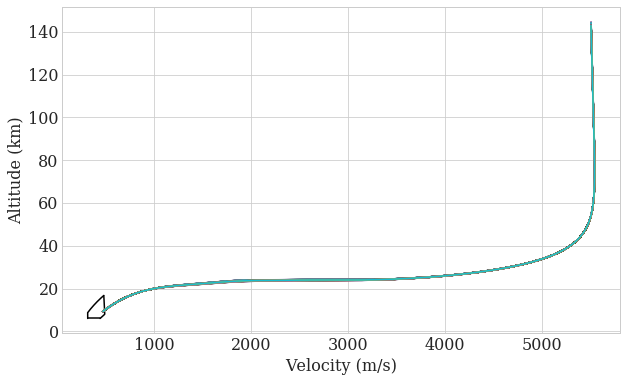

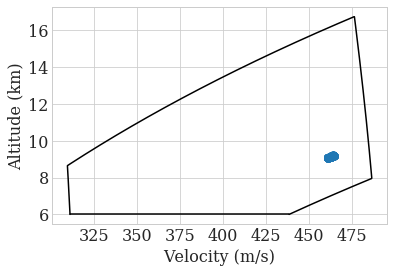

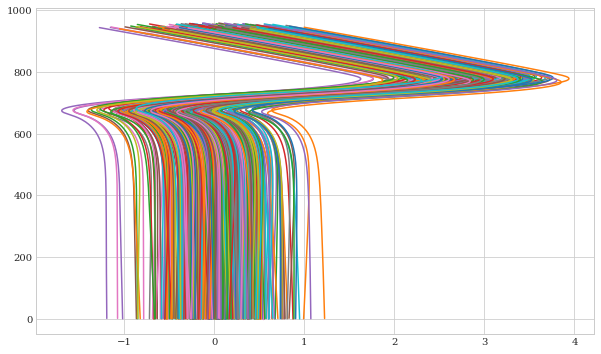

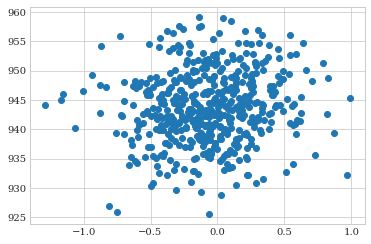

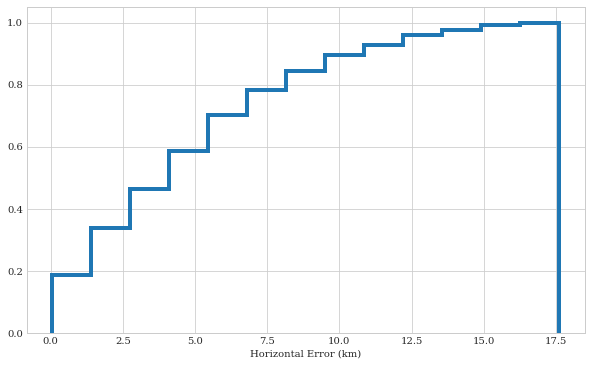

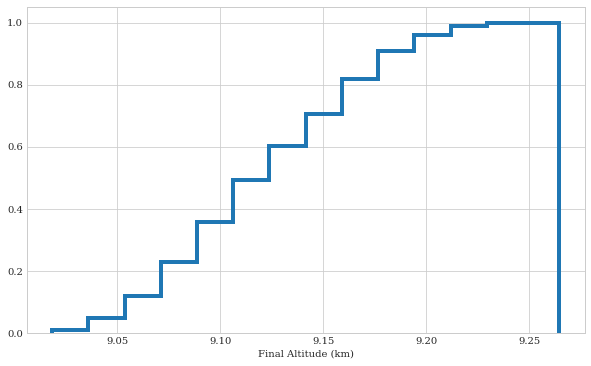

In [191]:
mc.plot()

# Landing Guidance - SRP
## Differential Flatness (BSpline) + SQP approach

In [ ]:
from EntryGuidance import bsplinePDG as PDG
reload(PDG)
PDG.optimize()

## GPOPS Solution to SRP 

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 
import seaborn
seaborn.set_style('whitegrid')
from scipy.io import savemat, loadmat
import os

from Utils.gpops import srp as srp_opt
from EntryGuidance.TrajPlot import TrajPlot

In [ ]:
x0 = [-3200., 0., 3200., 625., 60., -270., 8500.]
traj = srp_opt((x0,))
# print((traj['time'][-1]))
u = np.array(traj['control']).T
# plt.figure(1, figsize=(14,8))
# TrajPlot(*(np.array(traj['state'])[:,0:3].T), T=(u[0]*u[1:4]).T/1000 , show=True, figNum=1)

In [2]:
import chaospy as cp
x0 = [-3200., 0., 3200., 625., 0., -270., 8500.]
ux = cp.Uniform(x0[0]-1200,x0[0]+400)
uy = cp.Uniform(x0[1]-2000,x0[1]+2000)
uz = cp.Uniform(x0[2]-600,x0[2]+800)
uu = cp.Uniform(x0[3]-40,x0[3]+100)
uv = cp.Uniform(x0[4]-100,x0[4]+100)
uw = cp.Uniform(x0[5]-40,x0[5]+40)
D = cp.J(ux,uy,uz,uu,uv,uw)

R = D.sample(999, 'S').T
# R = uz.sample(100,'S')
print(R.shape)

(1000, 6)


From each trajectory, save the solution vector (7 initial costates + 1 final time) as well as the entire array of states and controls

In [ ]:
x0 = [-3200., 0., 3300., 625., 0., -270., 8500.]
savedir = "./data/mae278/test"
it0 = len([1 for file in os.listdir(savedir) if file.endswith('.mat')])
for it,r in enumerate(R, start=it0):
#     print("Solving from initial state {} m".format(r))
#     print("Iter {}".format(it))

    r = [float(ri) for ri in r]
    x0[0:6] = r
#     x0[2] = float(r)
    traj = srp_opt((x0,))
    
    
    t = np.array(traj['time']).squeeze()
    l = np.array(traj['costate'])
    sol = l[0].tolist() + [t[-1]]
    traj['time'] = t
    traj['costate'] = l
    traj['state'] = np.array(traj['state'])
    traj['control'] = np.array(traj['control'])
    traj['sol'] = sol
    traj.pop('timeRadau', None)
    traj.pop('controlRadau', None)
    traj.pop('pathmultipliers', None)

    savemat(savedir+"/srp_{}.mat".format(it), traj)

In [ ]:
loaddir = "./data/mae278/alt_sweep_fixed/"
plt.figure(100, figsize=(12,12))
z0 = []
sol = []
tf = []
for file in os.listdir(loaddir):
#     print(file)
    if not file.endswith('.mat'):
        continue
    data = loadmat(loaddir+file, squeeze_me=True)
    x = data['state'].T
#     tf.append(np.array(data['time']).squeeze()[-1])
    print(np.max(x[0]))
    if np.all(x[0]<=0):
        TrajPlot(*x[0:3], figNum=100)
    z0.append(x[2,0])
    sol.append(data['sol'])
I = np.argsort(z0)
# plt.figure(16,figsize=(12,12))
# plt.plot(np.array(z0)[I],np.array(sol)[I,:])
# plt.xlabel('Initial Altitude (m)')
# plt.ylabel('Costates')
# plt.legend(['x','y','z','u','v','z'])

In [25]:
print(np.mean(tf))
print(np.max(tf))
print(np.min(tf))

15.228431129802608
19.132580241869892
11.8704813225191


## Iterative Convex Optimization of Nonlinear Systems (ICONS)


In [9]:
import EntryGuidance.Convex_PS as Convex
from importlib import reload
reload(Convex)
OCP = Convex.OCP
import cvxpy as cvx
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 
import seaborn
seaborn.set_style('whitegrid')


In [10]:
class SRP(OCP):
    def __init__(self, x0, xf, ubounds, xf_idx=None, scale=1):
        # xf is a REDUCED list of final states, len(xf)=len(xf_idx)
        # xf_idx is a list of indices for fixed final states such that x[xf_idx] = xf
        self.vei = 0.00034 # escape velocity inverse= 1/(Isp*g0), system is linear with no mass loss when = 0        
        
        self.x0 = np.array(x0)
        
        if xf_idx is not None:
            assert len(xf)==len(xf_idx)
            self.xfi = xf_idx
        else:
            self.xfi = list(range(self.x0.size))
            
        self.scale = scale  
        self.ubounds = np.asarray(ubounds) / self.scale
        self.x0 = np.array(x0) / self.scale
        self.xf = np.array(xf)
        
    def dynamics(self, x, t, U):
#         u = U(t).T * self.scale
        u = U.T * self.scale
        p = x[0:3] * self.scale
        v = x[3:6] * self.scale
        m = x[6]   * self.scale
        
        g = np.array([0, 0, 3.71])
        if x.ndim>1:
            g = g[:,None]
        dx = np.empty(x.shape, dtype=x.dtype)     
        dx[0:3] = v
        dx[3:6] = u/m - g
        dx[6] = -self.vei * (u[0]**2 + u[1]**2 + u[2]**2)**0.5   
        return dx/self.scale
        
    def jac(self, x, u):
        u = u.copy() * self.scale
        m = x[6]*self.scale
        
        A = np.zeros((x.shape[1],7,7))
        A[:, 0:3][:, :, 3:6] = np.eye(3)
        A[:, 3:6][:, :, 6] = (-u/m**2).T

        B = np.zeros((x.shape[1],7,3))
        B[:, 3, 0] = 1/m
        B[:, 4, 1] = 1/m
        B[:, 5, 2] = 1/m 
        B[:, 6] = (-self.vei * u/(u[0]**2 + u[1]**2 + u[2]**2)**0.5).T
        return A,B 
    
    def check_jac(self, x, u):
        from Utils.DA import compute_jacobian
        
        xu = np.concatenate((x,u), axis=0)        
        return compute_jacobian(lambda xu: self.dynamics(xu[:7], 0, lambda t: xu[7:]), xu)
    
    def constraints(self, t, x, u, x_ref, u_ref):
        bc = [x[-1][self.xfi] == self.xf, x[0] == x_ref[0]]
        
        umin, umax = self.ubounds
        dT_max = 1*umax # Newtons
        dm = 500/self.scale # kg 
        constr = []
        for ti, xr in zip(t, x_ref):
#             du = u[ti]-u_ref[ti]
#             if ti>t[0]:
#                 dudt = (u[ti] - u[ti-1])
#                 constr += [cvx.norm(dudt) < 0.2 * umax]
            constr += [cvx.norm(u[ti])/umax <= 1] # Convex upper bound on total thrust
#             constr += [cvx.norm(u[ti])/umin >= 1] # Non-convex lower bound on total thrust
#             constr += [cvx.norm(du) <= dT_max]   # Convex upper bound on change in thrust

#             constr += [u[ti][1] > 0]
            if ti:
                constr += [x[ti][-1]-x[ti-1][-1] <= 0] # non-increasing mass 
#             constr += [cvx.norm(x[ti][-1]-xr[-1]) < dm] # Bound on change in mass 
        return constr + bc
        
    def mayer(self, xf):
        return 0 
#         return cvx.Problem(cvx.Minimize(-xf[-1]))
    
    def lagrange(self, t, x, u, xref, uref):
        return np.array([cvx.norm(ui) for ui in u])/self.ubounds[1]
#         return np.zeros((len(x),))
        
    def plot(self, T, U, X, J, meshpts, *args):
        """ Plots the results of the successive convex optimization """
        xopt = X[-1] * self.scale 
        uopt = U[-1] * self.scale 
        label = "Convex"
        print("Fuel consumed = {:.1f} kg".format(xopt[-1,0]-xopt[-1,-1]))
        
        plt.figure(1)
        plt.plot(T[-1], xopt[-1], label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Mass (kg)')
        
        plt.figure(2)
        plt.plot(T[-1], xopt[0:3].T, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        
        plt.figure(3)
        plt.plot(T[-1], xopt[3:6].T, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        
        plt.figure(4)
        plt.plot(T[-1], np.linalg.norm(uopt, axis=1), label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Thrust (N)')
        
        plt.figure(5)
        plt.plot(T[-1], uopt/np.linalg.norm(uopt, axis=1)[:,None], label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Control Directions')
        
        plt.figure(6)
        if np.max(J)/(np.min(J)+1e-8) > 10:
            plt.semilogy(J,'o-')
        else:
            plt.plot(J,'o-')
        plt.xlabel('Iteration')
        plt.ylabel('Cost Function')
        
#         self.mesh.plot()
        
    def guess(self):
        """ Generates a dictionary containing an initial guess at the solution"""
        guess = {}
        if False:
            data = loadmat("./data/mae278/srp_10.mat", squeeze_me=True)
            guess['time'] = data['time']
            guess['state'] = data['state']/self.scale 
            guess['mesh'] = [4]*3
            guess['control'] = data['control'][:,0:1]*data['control'][:,1:4]/self.scale 
            
        else: # Simple linear guess 
            guess['time'] = np.linspace(0,16)
            guess['mesh'] = [4]*3

            x_guess = np.array([np.linspace(x,1) for x in self.x0]).T
            x_guess[:,6] = np.linspace(self.x0[-1], 0.72*self.x0[-1])
            
            t = np.linspace(0,16,51)
            v = np.array([np.linspace(x, 1, 51) for x in self.x0[3:6]]).T
            guess['state'] = x_guess
            guess['control'] = np.diff(v, axis=0)/np.diff(t)[:,None] * x_guess[:,6:]
        return guess 
    
    def gpops(self):
        """ Generates the optimal solution using GPOPS II """
        from Utils.gpops import srp as srp_opt
        traj = srp_opt(([float(x0*self.scale) for x0 in self.x0],))

        u = np.array(traj['control']).T
        t = traj['time']
        x = np.array(traj['state']).T
        label = "GPOPS"
        plt.figure(1)
        plt.plot(t, x[-1], '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Mass (kg)')
        plt.legend()
        plt.figure(2)
        plt.plot(t, x[0:3].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        plt.legend()
        plt.figure(3)
        plt.plot(t, x[3:6].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.legend()
        
        plt.figure(4)
        plt.plot(t, u[0], '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Thrust (N)')
        plt.legend()
        
        plt.figure(5)
        plt.plot(t, u[1:4].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Control Directions')
        plt.legend()

In [11]:
m0 = 8500
x0 = np.array([-3000., 0, 2800, 625., -80, -270., m0])
xf = np.zeros((6,))
xfi = np.arange(6)
ubnds = np.array([40,70])*m0 # Newtons 
srp = SRP(x0=x0, xf=xf, xf_idx=xfi, ubounds=ubnds, scale=m0)
print(srp.ubounds)

[40. 70.]


Iteration 0
status:        optimal
optimal value: 17.332
solution time:  0.046 s
setup time:     0.02 s
penalty value:  0.0007778201958046753

Mesh refinement resulted in 3 segments with 13 collocation points

Iteration 1
status:        optimal
optimal value: 10.26
solution time:  0.068 s
setup time:     0.029 s
penalty value:  3.65088363524917e-08

Relative change in cost function = 68.93%
Iteration 2
status:        optimal
optimal value: 9.912
solution time:  0.069 s
setup time:     0.028 s
penalty value:  9.46153722180405e-08

Relative change in cost function = 3.50%
Mesh refinement resulted in 6 segments with 19 collocation points

Iteration 3
status:        optimal
optimal value: 9.89
solution time:  0.172 s
setup time:     0.066 s
penalty value:  2.889764517739681e-08

Relative change in cost function = 0.22%
Mesh refinement resulted in 8 segments with 37 collocation points

Iteration 4
status:        optimal
optimal value: 9.882
solution time:  0.242 s
setup time:     0.129 s
pe

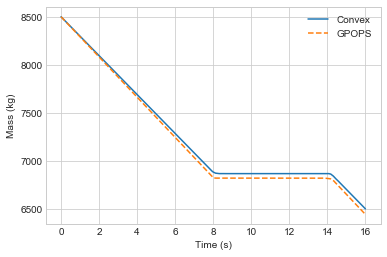

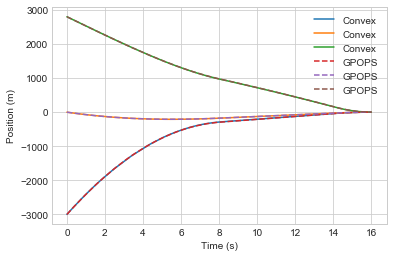

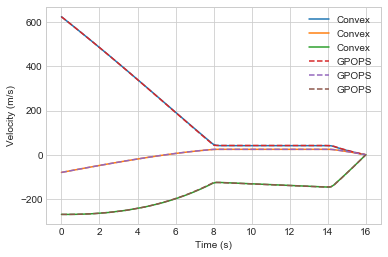

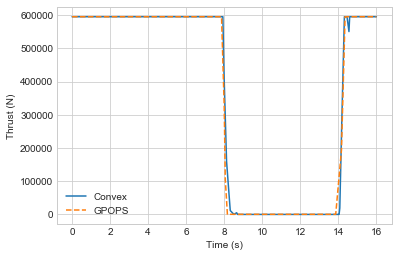

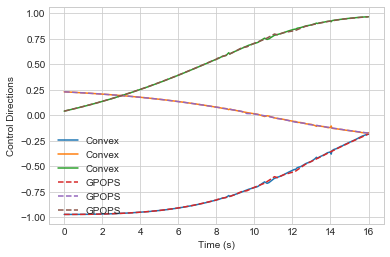

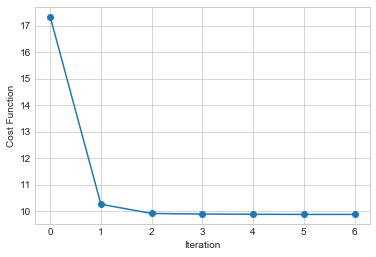

In [13]:
srp.solve(srp.guess(), max_size=300, max_iter=25) #scaling=np.array([10,5,10,1,1,1,15])*5
srp.gpops()


Verify that jacobian is implemented correctly 

In [148]:
x0 = srp.x0
u0 = np.array([70.,70,70])/srp.scale
u = np.array([60.,75,65])/srp.scale
x = np.array([-3100., 350, 3000, 615., -70, -260., m0*0.98])/srp.scale
# print(x)
# print(x0)
f0 = srp.dynamics(x0, 0, lambda t: u0)
f = srp.dynamics(x, 0, lambda t: u)
print(f)
print(f0)
A,B = srp.jac(np.array([x0,x]).T, np.array([u0,u]).T)
flinear = f0 + (A[0].dot(x-x0) + B[0].dot(u-u0))
print(flinear)
print(np.linalg.norm(f-flinear, np.inf))

[ 7.23529412e-02 -8.23529412e-03 -3.05882353e-02  8.47397783e-07
  1.05924723e-06 -4.35552574e-04 -4.63896540e-06]
[ 7.35294118e-02 -9.41176471e-03 -3.17647059e-02  9.68858131e-07
  9.68858131e-07 -4.35501730e-04 -4.84974226e-06]
[ 7.23529412e-02 -8.23529412e-03 -3.05882353e-02  8.49826990e-07
  1.05743945e-06 -4.35551557e-04 -4.61880215e-06]
2.0163248380274508e-08


In [149]:
A,B = srp.jac(np.array([x0,x]).T, np.array([u0,u]).T)
J = srp.check_jac(x, u)

print(J.shape)
print(A.shape)
print(B.shape)
Jana = np.concatenate((A[1],B[1]), axis=1)
err = np.abs(Jana-J)
print(np.linalg.norm(err, np.inf))
# print(err)

(7, 10)
(2, 7, 7)
(2, 7, 3)
1.3552527156068805e-19


## Indirect Approach

In [7]:
# These are closed loop dynamics that depend on the initial costate 
def dynamics(x, t, l0):
    # Problem constants
    Isp = 290;
    g0 = 9.81;
    ve = Isp*g0;
    Tmax = 70*8500
    Tmin = 40*8500
    
    # States being integrated
    r = x[0:3]
    v = x[3:6]
    m = x[6]
    lm = x[7] # Mass costate 
    
    # Costates
    lr = l0[0:3]
    lv0 = l0[3:6]
    lv = lv0 - lr*t
    u = -lv/np.linalg.norm(lv) # Optimal thrust direction
    
    # Optimal thrust magnitude
    S = -lm/ve + np.dot(lv, u)/m
    if S < 0:
        T = Tmax
    else:
        T = Tmin
    
    # State derivatives
    g = np.array([0,0,3.71])
    dx = np.empty(x.shape)     
    dx[0:3] = v
    dx[3:6] = T*u/m - g
    dx[6] = -T/ve    
    dx[7] = T*np.dot(lv, u)/m**2
    return dx

In [7]:
# l0 = np.array([0.204346904081385,	0.0663646852284269,	0.201041129500207,	3.17235427027352,	0.470730385571971,	0.565067899039915,	-0.748860889946803])
# x0 = np.array([-3200., 400, 3200, 625., 0, -270., m0, l0[-1]])
# tf = 14.0035
data = loadmat("./data/mae278/srp_566.mat", squeeze_me=True)
x0 = data['state'][0]
l0 = data['costate'][0]
x0 = np.append(x0, l0[-1])
tf=16
print("True prop usage = {} kg".format(data['state'][0,6]-data['state'][-1,6]))

True prop usage = 2412.5166200060476 kg


In [10]:
data = loadmat("./data/mae278/srp_566.mat", squeeze_me=True)
x0 = data['state'][0]
l0 = data['costate'][0]
x0 = np.append(x0, l0[-1])
t = np.linspace(0,tf)
X = odeint(dynamics, x0, t, args=(l0,))
print("Miss distance: {:.1f} m".format(np.linalg.norm(X[-1,:3])))
print("Velocity error: {:.1f} m".format(np.linalg.norm(X[-1,3:6])))
print("Prop used: {:.2f}".format(X[0,6]-X[-1,6]))

Miss distance: 54.4 m
Prop used: 2426.57


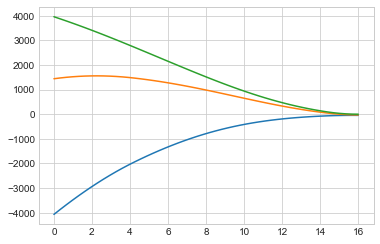

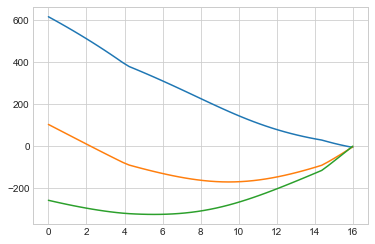

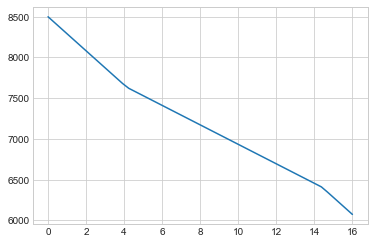

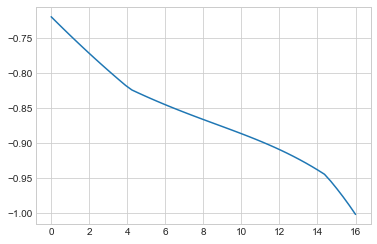

In [9]:
plt.figure()
plt.subplot(131)
plt.plot(t, X[:,0:3])
plt.subplot(132)
plt.plot(t, X[:,3:6])
plt.subplot(133)
plt.plot(t, X[:,6])
# plt.figure()
# plt.plot(t, X[:,7])

In [7]:
from EntryGuidance import Riccati
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 


In [8]:
A = lambda x: np.array([x]).squeeze()
B = lambda x,u: np.array([1+x**2])
C = lambda x: np.array([1]) # Output equation linearization 
Q = lambda x: np.array([1-0.1*x**2]).squeeze() # State weight - less weight when far away 
R = lambda t: np.array([0.5/(1+t)]) # Control weight
z = lambda t: np.array([1+np.sin(t)+0.2*np.cos(2*t)/2]) #np.array([0]) # Reference trajectory
F = lambda x: Q(x)/10 #np.array([0]) # Final State weight 

tf = 12

x0 = np.array([1])
x, u, K = Riccati.ASRE(x0, tf, A, B, C, Q, R, F, z, tol=1e-3, max_iter=50, n_discretize=5000)
t = np.linspace(0, tf, x.size)

Uc = lambda T,X: interp1d(t, u, axis=0, bounds_error=False, fill_value=0)(T) - interp1d(t, K.squeeze(), axis=0, bounds_error=False, fill_value=0)(T)*(X - interp1d(t, x, axis=0, bounds_error=False, fill_value=0)(T))
Uo = lambda T,X: interp1d(t, u, axis=0, bounds_error=False, fill_value=0)(T) 

d = lambda x,t: 0.1*np.sin(t)*x
f = lambda x,t,u: x**2 + (1+x**2)*u(t,x) + d(x,t)

x_ol = odeint(f, x0, t, args=(Uo,)) # This should match with zero error essentially 
x_cl = odeint(f, np.linspace(0,2,10), t, args=(Uc,))
u_cl = [Uc(ti,xi) for ti,xi in zip(t,x_cl.squeeze())]
ref = z(t).squeeze()

Approximating Sequence of Riccati Equations
Max iterations: 50
Current iteration: 1
Current cost: 0.7895710251969738
Current iteration: 2
Current cost: 0.6088560399458006
Current iteration: 3
Current cost: 0.5991445034266731
Current iteration: 4
Current cost: 0.5963617844606172
Current iteration: 5
Current cost: 0.5960904171646377
Convergence achieved. 


E:\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


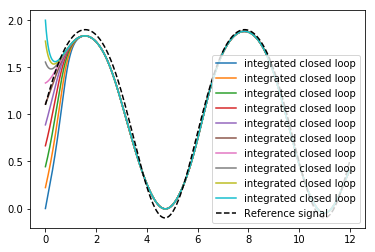

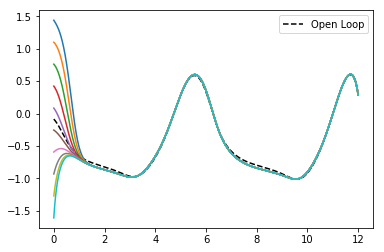

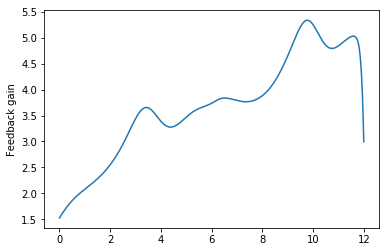

In [9]:
# plt.plot(t, x, 'mo',label='approx')
# plt.plot(t, x_ol, 'k-^', label='integrated open loop')
plt.plot(t, x_cl, label='integrated closed loop')
plt.plot(t, ref, 'k--', label='Reference signal')

plt.legend()

plt.figure()
plt.plot(t, u, 'k--', label='Open Loop')
plt.plot(t, u_cl)
plt.legend()

plt.figure()
plt.plot(t, K.squeeze())
plt.ylabel('Feedback gain')
plt.show()

## Closed loop covariance propagation
How does saturation effect the evolution?

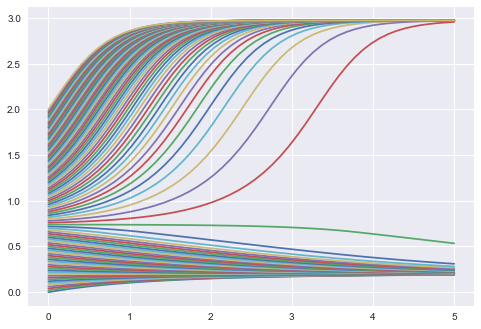

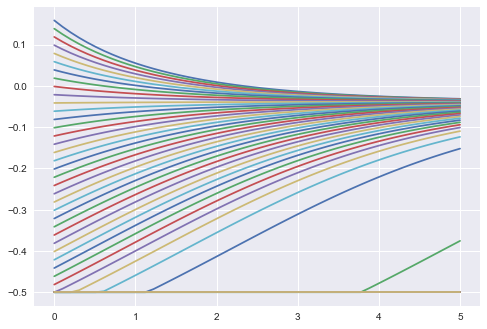

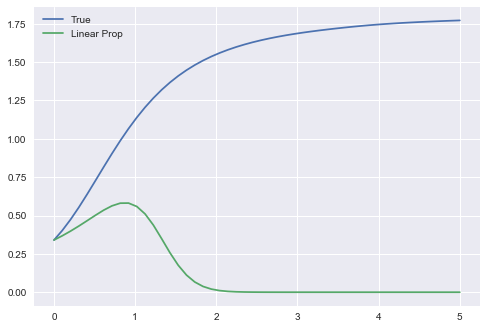

In [5]:
from EntryGuidance.Unscented import Transform 
tf = 5

x0 = np.linspace(0.,2,101)
t = np.linspace(0, tf, 50)

umax = 0.5
k = 1.
U = lambda t,x: np.clip(-np.sin(1)-k*(x-1), -umax, umax)
f = lambda x,t: np.sin(x)*x + U(t,x)
fp= lambda p,t,x: 2*p*(np.sin(x(t)) + x(t)*np.cos(x(t)) - k)

x = odeint(f, x0, t)
x_mean = odeint(f, np.mean(x0), t)
# x_mean = np.mean(x, axis=1)

u = [U(ti, xi) for ti,xi in zip(t,x.squeeze())]
P =  np.var(x, axis=1)
xt = interp1d(t,x_mean, axis=0, bounds_error=False, fill_value=(x_mean[0],x_mean[-1]))
Plin = odeint(fp, P[0], t, args=(xt,))

plt.figure()
plt.plot(t,x)

plt.figure()
plt.plot(t,u)

plt.figure()
plt.plot(t,P, label='True')
plt.plot(t,Plin, label='Linear Prop')
plt.legend()
plt.show()

In [1]:
import cvxpy as cvx

In [4]:
n = 3
x = cvx.Variable(n)
H = np.diag([1,-1,1.])
c = np.random.random((n,))

# print cvx.quad_form(x,H)
# print x[0]
constraint = [cvx.quad_form(x,np.abs(H)) < 1]
# constraint = [(x[0]**2 - x[1]**2 + x[2]**2)**2 < 1]

problem = cvx.Problem(cvx.Minimize(c*x), constraint)
problem.solve()
print x.value
print x.value.A.T.dot(np.abs(H)).dot(x.value.A)

[[-0.59096725]
 [-0.39423826]
 [-0.70379961]]
[[1.]]


In [7]:
print (cvx.quad_form(x,(H)) < 1).is_dcp()

False


e:\anaconda\lib\site-packages\cvxpy\atoms\quad_form.py:82: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
